# Spatially Enabled DataFrame

<center>
<img src="./img/pandas_globe.png" height=600, width=600/></center>

## Basic Operations

In order to add spatial abilites to spaial dataframe, we have added two custom namespaces into Pandas DataFrame: `geom` and `spatial`.
   + `geom` on the row level
   
   ```python
   >>> df['SHAPE'].geom.area
   ```
    
   + `spatial` on the the DataFrame/dataset level
    
   ```python
   >>> df.spatial.project_as(4326)
   ```

That's why we start by importing `GeoAccessor` and `GeoSeriesAccessor`.

In [1]:
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor # correspond to "geom" and "spatial" namespaces

### Reading a Feature Class
Let's read a simple polygon-based zoning feature class into a spatial dataframe

In [2]:
data = "./data/sample_data.gdb/Zoning" # simple polygon-based zoning feature class
sdf = pd.DataFrame.spatial.from_featureclass(data)

In [3]:
sdf.head()

,OBJECTID,Zoning,Shape_Leng,MuniCode,ZoningName,GlobalID,Link,Shape_Length,Shape_Area,SHAPE
0,1,C-1,74321.375928,https://www.municode.com/library/ga/dunwoody/c...,Local Commercial,{92E5A5DD-1249-4B85-8805-94F33C388F30},<a href='https://www.municode.com/library/ga/d...,74321.375928,1.377559e+07,"{""rings"": [[[2242922.9448516667, 1428590.30388..."
1,2,C-1c,1709.723755,https://www.municode.com/library/ga/dunwoody/c...,Local Commercial,{C6F4C26A-E1B6-429A-B250-D667C4A05366},<a href='https://www.municode.com/library/ga/d...,1709.723755,8.268644e+04,"{""rings"": [[[2244762.3210941665, 1428362.87585..."
2,3,C-2,5226.509130,https://www.municode.com/library/ga/dunwoody/c...,General Commercial,{74CC736F-CC12-4400-89B1-B2565DDBFD9C},<a href='https://www.municode.com/library/ga/d...,5226.509130,6.784930e+05,"{""rings"": [[[2265042.980992086, 1434626.455850..."
3,5,NS,8441.468446,https://www.municode.com/library/ga/dunwoody/c...,Neighborhood Shopping,{EA907C8F-5689-4519-880C-F0229FA96236},<a href='https://www.municode.com/library/ga/d...,8441.468446,9.861724e+05,"{""rings"": [[[2255173.350140836, 1439479.499949..."
4,6,O-D,13010.432794,https://www.municode.com/library/ga/dunwoody/c...,Office-Distribution,{8490C998-9AD7-4224-96E0-DA58914D9675},<a href='https://www.municode.com/library/ga/d...,13010.432794,2.740823e+06,"{""rings"": [[[2256905.097989667, 1426518.668916..."


Query the SHAPE attribute for a specific row. It will print out the boundary of that shape.

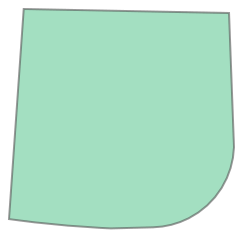

In [4]:
sdf.iloc[1].SHAPE

###  Row level operations

#### Calculating Centroid for each row/feature

In [4]:
sdf['centers'] = sdf.SHAPE.geom.centroid
sdf['centers'].head()

0      (2246635.4023285583, 1430360.79215311)
1     (2244730.532443829, 1428473.1689439863)
2    (2264768.3837722465, 1434785.5700330734)
3     (2255113.134710077, 1439986.1091726571)
4     (2255507.380357568, 1427113.2501990118)
Name: centers, dtype: object

####  Calculating Area

In [5]:
sdf.SHAPE.geom.get_area("PLANAR","ACRES").sum()

7207.710345042221

###  Dataset level operations

#### Get bbox for the entire dataset

In [42]:
sdf.spatial.bbox

{'rings': [[[2241652.5139935836, 1424875.1078986675],
   [2241652.5139935836, 1440428.2119630054],
   [2266014.037120834, 1440428.2119630054],
   [2266014.037120834, 1424875.1078986675],
   [2241652.5139935836, 1424875.1078986675]]],
 'spatialReference': {'wkid': 102667}}

#### Reprojecting

In [39]:
print(sdf.spatial.sr)
sdf.spatial.project(4326)
print(sdf.spatial.sr)

{'wkid': 102667}
{'wkid': 4326}


These are just simple examples, there are many other things we can do with SeDF in terms of spatial operations. You can find more info on our API reference.

## Visualization

<center>
<img src="./img/panda_map.jpg"height=300, width=300/></center>

The Spatially Enabled Dataframe has a `plot()` method that allows you to visualize data on a map widget.

### Simple Rendering

Let's read a census data on major cities and load that into a Spatially Enabled DataFrame

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
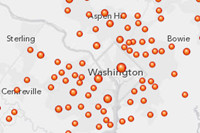

In [5]:
from arcgis.gis import GIS
gis = GIS(profile='your_online_profile')

item = gis.content.get("85d0ca4ea1ca4b9abf0c51b9bd34de2e")
item

In [6]:
flayer = item.layers[0]
df = flayer.query(where="AGE_45_54 < 1500", as_df=True) # select a subset

In [7]:
first_map = gis.map('New York, NY')
first_map.basemap = 'dark-gray'
first_map

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
df.spatial.plot(map_widget=first_map)

True

Note that this is all happening locally in the memory and nothing was sent to the server. Very performant in that sense.

### Customize symbols

I'm plotting the same dataset with a custom renderer.

In [9]:
m2 = gis.map('New York, NY')
m2.basemap = 'dark-gray'
m2

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
df.spatial.plot(map_widget=m2,
                symbol_style='s', # s stands for square rather than circles. I'm gonna use
                outline_color='YlOrBr', # yellow outline. I want it to be
                marker_size=10, # size of the marker
                colors='Reds_r' # color of symbol
               ) 

True

So far we have been working with only one symbol. We can also do...

### Unique Renderer
Renders each unique value with a different symbol. Here I'm going plot the same data based on states. Each state will have a different color.

In [11]:
m3 = gis.map('Reno, NV', zoomlevel=4)
m3.center = [39,-98]
m3

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [12]:
df.spatial.plot(map_widget = m3,
                renderer_type='u', # unique value renderer 
                col='ST'  # column = "state", base col
               )

True

You can do ... as well.

### Class Break Renderer

Includes esriClassifyNaturalBreaks, esriClassifyEqualInterval, etc.

In [13]:
m4 = gis.map('Reno, NV', zoomlevel=4)
m4.center = [39,-98]
m4

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [16]:
df.spatial.plot(map_widget=m4,
               renderer_type='c',  # class break renderer
               method='esriClassifyNaturalBreaks',  # classification algorithm. Equal intervals as well.
               class_count=20,  
               col='POPULATION',  # base column
               cmap='gnuplot2_r', 
               alpha=0.7
               )

True

Now this is rendered using class break renderer.
- What's even better is that we can pop up the legend as well to make more sense of the visualization.

In [15]:
m4.legend = True

So far we have been working with point data, but it can actually work with any geometry types.

### Rendering Polygon Example


Let's read a random polygon-based data (county level census data) into SeDF.

In [17]:
item = gis.content.get("8444e275037549c1acab02d2626daaee")
flayer = item.layers[0]
county_sdf = flayer.query().sdf

In [18]:
m5 = gis.map('California, US')
m5

MapView(layout=Layout(height='400px', width='100%'))

Use a similar setting as above.

In [19]:
county_sdf.spatial.plot(map_widget=m5,
                        renderer_type='c', # class break renderer  
                        method='esriClassifyNaturalBreaks',  # equal intervals
                        class_count=7,  
                        col='POPULATION', # base column
                        cmap='RdPu',  
                        alpha=0.8,
                        line_width=.25)

True

Now I get a beautiful polygon-based map that is fully interative.

## Spatial Indexing

- Quickly find spatial locations, but they are on demand. Default is quadtree because it can be built very fast.

### Visulaize Quadtree

<img src="./img/point_quadtree.png" />

It starts by dividing your space into 4 quadrants and then keep dividing each quadrants into smaller ones until it meets a threshold. This way, it reduces the time complexity during search.

### Spatial Index Example

I'm going to take our major city data again and build a spatial index.

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
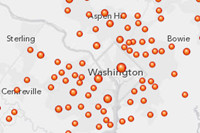

In [20]:
item = gis.content.get("85d0ca4ea1ca4b9abf0c51b9bd34de2e")
item

In [21]:
sdf = item.layers[0].query(as_df=True, out_sr=4326) # Major US Cities

Here I'm building a `quadtree`. You can create R-tree index as well which gives you more capabilites, but they are not necessary in this case

In [22]:
index = sdf.spatial.sindex(stype='quadtree')

Now if I want select all points within New Jersey. I can just do a intersect with the bbox of New Jersey

In [23]:
%%time
nj_cities = index.intersect((-75.55956796790353, 38.928522146813044, 
                             -73.9024505439044, 41.35763612214295)) # returns a list

CPU times: user 223 µs, sys: 1e+03 ns, total: 224 µs
Wall time: 229 µs


In [24]:
m6 = gis.map("New Jersey")
m6

MapView(layout=Layout(height='400px', width='100%'))

In [25]:
sdf.iloc[nj_cities].spatial.plot(m6)

True

Notice that there are still some points that are from New York and Pennsylvania, because New Jersey is not a perfect square.

### Get points that are exactly from NJ
Take advantage of some other geometry operations in SeDF.

<Item title:"New Jersey State Boundary" type:Feature Layer Collection owner:NJOGIS>
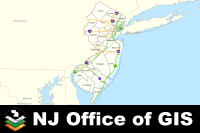

In [26]:
nj_boundary = gis.content.get("e4bb3aeab5e14422be1727ccbe0c1fb9")
nj_boundary

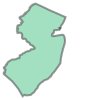

In [27]:
nj_bounds = nj_boundary.layers[0].query(out_sr=4326, as_df=True)
nj_boundary = nj_bounds.iloc[0].SHAPE
nj_boundary

In [28]:
extent_cities = sdf.iloc[nj_cities].reset_index()
extent_cities.ST.unique()

array(['PA', 'NJ', 'NY', 'DE'], dtype=object)

Use `within()` to query out points that are within this boundary of NJ

In [29]:
g_query = extent_cities.SHAPE.geom.within(nj_boundary) == True
extent_cities[g_query].spatial.plot(m6, cmap='Accent')

True

## Custom Analysis

<img src="./img/panda_analysis.png" height=600, width=600/>

Besides the built-in functions in Python API, we can pass SeDF directly to other data science libaries such as scikit-learn.

Here I have a dataset of Airbnb reviews and I'd like to run K-means to find similar homes based on review scores.

In [30]:
df = pd.read_csv("./data/listings.csv", low_memory=False) # it is just a regular df at this point
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,f,NaN,{Amsterdam},t,f,strict_14_with_grace_period,f,f,1,2.10
1,3209,https://www.airbnb.com/rooms/3209,20181206172549,2018-12-06,"Quiet apt near center, great view",You will love our spacious (90 m2) bright apar...,"Our apartment has lots of light, a balcony and...",You will love our spacious (90 m2) bright apar...,none,Welcome to the Spaarndammerbuurt! From the beg...,...,f,NaN,{Amsterdam},f,f,moderate,f,f,1,1.03
2,20168,https://www.airbnb.com/rooms/20168,20181206172549,2018-12-06,100%Centre-Studio 1 Private Floor/Bathroom,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,NaN,{Amsterdam},f,f,strict_14_with_grace_period,f,f,2,2.18


In [31]:
data = df[~df['review_scores_value'].isna()].copy().reset_index(drop=True)

# geoenable it
sdf_airbnb = pd.DataFrame.spatial.from_xy(df=data, y_column='latitude', x_column='longitude', sr=4326)

In [32]:
m10 = gis.map()
sdf_airbnb.spatial.full_extent
m10.extent = sdf_airbnb.spatial.full_extent
m10

MapView(layout=Layout(height='400px', width='100%'))

In [34]:
sdf_airbnb[['SHAPE']].spatial.plot(map_widget=m10)

True

### K-Means Clustering

One of the simplest clustering algorithms, to find similar homes based review scores.

In [35]:
from sklearn import cluster

Data cleanup: 
- Remove and NaN or NULL value from the columns of interest
- Convert price from string to numeric
- Select only 'Entire home/apt' 

In [36]:
q = (sdf_airbnb['room_type'] == 'Entire home/apt') & (sdf_airbnb['beds'] >=4)

ratings = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
          'review_scores_value', 'latitude', 'longitude']

sdf_airbnb = (sdf_airbnb
              .loc[q]
              .dropna(axis=0, subset=ratings)
              .copy()
              .reset_index(drop=True))

sdf_airbnb['RENTALPRICE'] = (sdf_airbnb
                                    .price
                                    .str
                                    .replace("$", "")
                                    .str.replace(",","")
                             .apply(float))

Use elbow method to find the best cluster number.

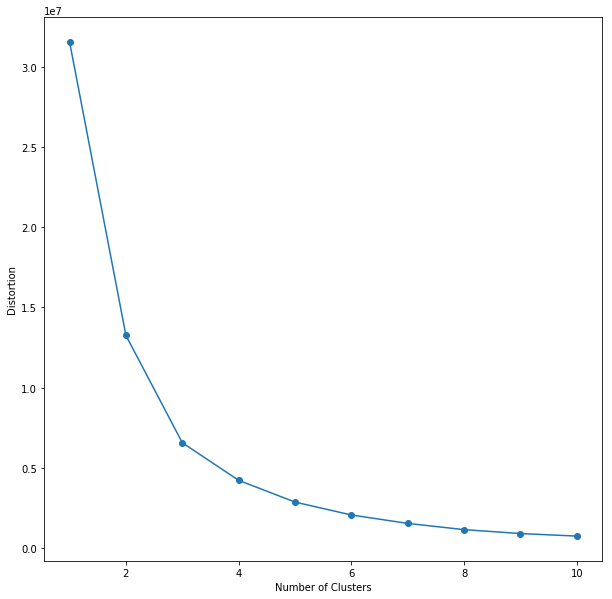

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
distortions = []
for i in range(1,11):
    km = cluster.KMeans(n_clusters=i,
           init='k-means++',
           n_init=10,
           max_iter=300,
           random_state=1)
    km.fit(sdf_airbnb[['RENTALPRICE']])
    distortions.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

The horizontal axis is cluster #; The vertical axis is distortion.
As we can see, the slope changes the most at cluster number 3, meaning it is a good cluster number.

In [38]:
# feed the data into the K-means algorihtm
kmeans5 = cluster.KMeans(n_clusters=3, # cluster number
                        init='random',
                        n_init=10,
                        max_iter=300,
                        random_state=0)
k5cls = kmeans5.fit_predict(sdf_airbnb[['RENTALPRICE']])
sdf_airbnb['class'] = k5cls

In [39]:
display_columns = ['SHAPE', 'class', 'name', 'summary', "price"]

In [40]:
# plot out the results
m11 = gis.map()
m11.extent = sdf_airbnb.spatial.full_extent
m11

MapView(layout=Layout(height='400px', width='100%'))

In [41]:
sdf_airbnb[display_columns].spatial.plot(map_widget=m11,
               renderer_type='u',  # for unique renderer
               col='class',  # numeric column to classify
               cmap='gist_ncar',  
               line_width=0,
               alpha=0.7  # specify opacity
               )

True

In [42]:
m11.legend = True

It shows how easy it is to use SeDF to connect the GIS data with the Python and data science world.